In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\messa\Downloads\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\messa\Downloads\Anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\messa\Downloads\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "d:\messa\Downloads\Anaconda\L

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

In [ ]:
data=pd.read_csv('/Data/french_tweets.csv')
data.tail()

,label,text
1526719,1,"Oui, cela fonctionne mieux que de l'attendre à..."
1526720,1,Je viens de me réveiller. Ne pas avoir d'école...
1526721,1,Thewdb.com - très cool d'entendre les vieilles...
1526722,1,Êtes-vous prêt pour votre mojo makeover? Deman...
1526723,1,Joyeux 38ème anniversaire à mon livre de tous ...


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vérifier la structure des données
print(data.info())
print("\nDistribution des sentiments :\n", data['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526724 entries, 0 to 1526723
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1526724 non-null  int64 
 1   text    1526724 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.3+ MB
None

Distribution des sentiments :
 label
0    771604
1    755120
Name: count, dtype: int64


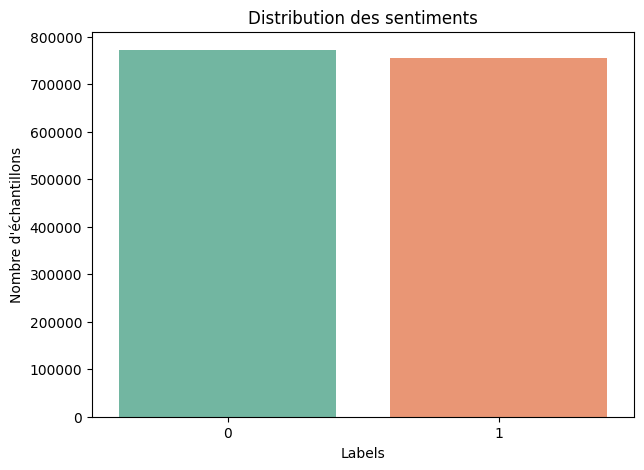

In [5]:

# Visualisation avec seaborn
plt.figure(figsize=(7,5))
sns.countplot(x='label', data=data, palette='Set2')
plt.title("Distribution des sentiments")
plt.xlabel("Labels")
plt.ylabel("Nombre d'échantillons")
plt.show()

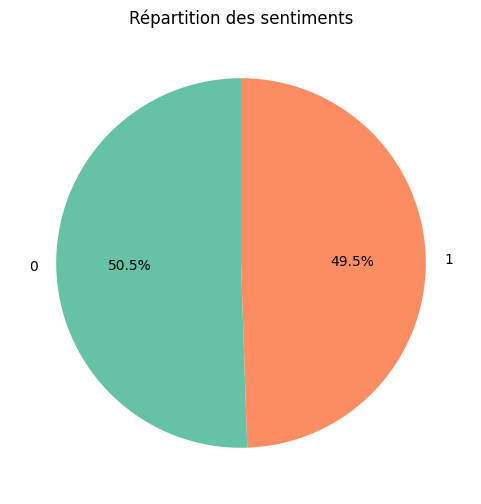

In [6]:
# Diagramme circulaire
plt.figure(figsize=(6,6))
data['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.title("Répartition des sentiments")
plt.ylabel("")  # Pour enlever le label 'label'
plt.show()

In [7]:
# Limiter à 50 000 tweets par classe
data = data.groupby('label').apply(lambda x: x.sample(n=50000, random_state=42)).reset_index(drop=True)

/tmp/ipykernel_36/1083992848.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('label').apply(lambda x: x.sample(n=50000, random_state=42)).reset_index(drop=True)


In [8]:
# Vérifier la nouvelle distribution des classes
print(data['label'].value_counts())

label
0    50000
1    50000
Name: count, dtype: int64


In [9]:
# Cellule pédagogique unique — nettoyage de texte pas à pas (exécution + explications)
import re
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd

In [10]:
nltk.download('stopwords', quiet=True)
try:
    stop_words = set(stopwords.words('french'))
except LookupError:
    # Si téléchargement échoue, afficher message clair
    print("Erreur: la ressource 'stopwords' de NLTK est introuvable.")
    print("Exécutez: nltk.download('stopwords') puis relancez la cellule.")
    raise

In [11]:
# Petite explication (affichée)
print("QU'EST-CE QU'UN STOPWORD ?")
print("-" * 60)
print("Un *stopword* est un mot très fréquent mais peu informatif (ex : 'et', 'la', 'de', 'un').")
print("On les retire souvent avant d'entraîner un modèle NLP pour se concentrer sur les mots porteurs de sens.")
print(f"Nombre de stopwords (français) chargés : {len(stop_words)}")
print("Exemples de stopwords :", sorted(list(stop_words))[:30])
print("\n" + "="*80 + "\n")


QU'EST-CE QU'UN STOPWORD ?
------------------------------------------------------------
Un *stopword* est un mot très fréquent mais peu informatif (ex : 'et', 'la', 'de', 'un').
On les retire souvent avant d'entraîner un modèle NLP pour se concentrer sur les mots porteurs de sens.
Nombre de stopwords (français) chargés : 157
Exemples de stopwords : ['ai', 'aie', 'aient', 'aies', 'ait', 'as', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avez', 'aviez', 'avions', 'avons', 'ayant', 'ayante', 'ayantes']




In [12]:
# --- Exemple de texte brut (typique d'un tweet / message) ---
exemple = "Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com @Pierre123 😃 J'ai 2 chats et 1 chien."
print("Texte original :")
print(exemple)
print("\n" + "-"*80 + "\n")

Texte original :
Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com @Pierre123 😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------



In [13]:
# --- Étape 1 : suppression des mentions (@utilisateur) ---
step1 = re.sub(r'@\w+', '', exemple)
print("Étape 1 — Suppression des mentions (@utilisateur) :")
print(step1)
print("\n" + "-"*80 + "\n")

Étape 1 — Suppression des mentions (@utilisateur) :
Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com  😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------



In [14]:
# --- Étape 2 : suppression des URLs ---
step2 = re.sub(r'http\S+|www\S+|https\S+', '', step1, flags=re.MULTILINE)
print("Étape 2 — Suppression des URLs :")
print(step2)
print("\n" + "-"*80 + "\n")

Étape 2 — Suppression des URLs :
Bonjour à tous !!! Je vais vous partager un lien utile :   😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------



In [15]:
# --- Étape 3 : suppression de la ponctuation ASCII (string.punctuation) ---
step3 = step2.translate(str.maketrans('', '', string.punctuation))
print("Étape 3 — Suppression de la ponctuation (ASCII) :")
print(step3)
print("\nRemarque : certains signes unicode (ex: guillemets typographiques) peuvent rester.")
print("\n" + "-"*80 + "\n")

Étape 3 — Suppression de la ponctuation (ASCII) :
Bonjour à tous  Je vais vous partager un lien utile    😃 Jai 2 chats et 1 chien

Remarque : certains signes unicode (ex: guillemets typographiques) peuvent rester.

--------------------------------------------------------------------------------



In [16]:
# --- Étape 4 : suppression des chiffres ---
step4 = re.sub(r'\d+', '', step3)
print("Étape 4 — Suppression des chiffres :")
print(step4)
print("\n" + "-"*80 + "\n")

Étape 4 — Suppression des chiffres :
Bonjour à tous  Je vais vous partager un lien utile    😃 Jai  chats et  chien

--------------------------------------------------------------------------------



In [17]:

# --- Étape 5 : conversion en minuscules ---
step5 = step4.lower()
print("Étape 5 — Conversion en minuscules :")
print(step5)
print("\n" + "-"*80 + "\n")

Étape 5 — Conversion en minuscules :
bonjour à tous  je vais vous partager un lien utile    😃 jai  chats et  chien

--------------------------------------------------------------------------------



In [18]:
# --- Étape 6 : suppression des stopwords ---
tokens = step5.split()
kept_tokens = [w for w in tokens if w not in stop_words]
step6 = " ".join(kept_tokens)
print("Étape 6 — Suppression des stopwords :")
print("Tokens avant suppression :", tokens)
print("Tokens après suppression  :", kept_tokens)
print("\nTexte final nettoyé :")
print(step6)
print("\n" + "="*80 + "\n")

Étape 6 — Suppression des stopwords :
Tokens avant suppression : ['bonjour', 'à', 'tous', 'je', 'vais', 'vous', 'partager', 'un', 'lien', 'utile', '😃', 'jai', 'chats', 'et', 'chien']
Tokens après suppression  : ['bonjour', 'tous', 'vais', 'partager', 'lien', 'utile', '😃', 'jai', 'chats', 'chien']

Texte final nettoyé :
bonjour tous vais partager lien utile 😃 jai chats chien




In [19]:
# --- Fonction utilitaire finale (même pipeline, sans prints) ---
def clean_text(text, stop_words=stop_words):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

In [20]:
# --- Application au DataFrame 'data' si présent, sinon démonstration sur un petit DataFrame ---
if 'data' in globals() and isinstance(data, pd.DataFrame) and 'text' in data.columns:
    # On n'écrase pas 'data' si l'utilisateur l'a déjà défini — on ajoute juste la colonne
    data['cleaned_text'] = data['text'].apply(clean_text)
    print("Application faite sur votre DataFrame 'data'. Aperçu (avant / après) :")
    display(data[['text', 'cleaned_text']].head(5))
else:
    demo = pd.DataFrame({
        'text': [
            exemple,
            "Super offre !! Visitez www.offre.com maintenant. @Store 50% OFF!!",
            "Demain 10h réunion avec le Dr. Dupont - confirmez svp."
        ]
    })
    demo['cleaned_text'] = demo['text'].apply(clean_text)
    print("Aucun DataFrame 'data' trouvé — démonstration sur un petit DataFrame 'demo' :")
    display(demo)

Application faite sur votre DataFrame 'data'. Aperçu (avant / après) :


,text,cleaned_text
0,"Non, je ne la regarde pas, idk elle.",non regarde idk
1,"- Très, très vrai.",très très vrai
2,Allongé au lit et essayant de dormir ne se pas...,allongé lit essayant dormir passe dois être he...
3,"S'endormir, rêver à propos de Tom et un amour ...",sendormir rêver propos tom amour jamais lt bye...
4,"Avoir eu des problèmes majeurs avec la santé, ...",avoir problèmes majeurs santé tension artériel...


In [21]:
# Nettoyage de texte
import re
import string
from nltk.corpus import stopwords
import nltk

In [22]:
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

def clean_text(text):
    # Enlever les mentions (@utilisateur)
    text = re.sub(r'@\w+', '', text)
    # Enlever les URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Enlever les ponctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Enlever les chiffres
    text = re.sub(r'\d+', '', text)
    # Convertir en minuscules
    text = text.lower()
    # Enlever les stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Appliquer le nettoyage sur la colonne 'text'
data['cleaned_text'] = data['text'].apply(clean_text)

# Visualiser un exemple avant/après
print("Avant nettoyage:", data['text'][0])
print("Après nettoyage:", data['cleaned_text'][0])

Avant nettoyage: Non, je ne la regarde pas, idk elle.
Après nettoyage: non regarde idk


In [24]:
# Diviser tous les textes nettoyés en mots individuels
all_words = " ".join(data['cleaned_text']).split()

In [25]:
# Créer un ensemble pour obtenir les mots uniques
unique_words = set(all_words)

In [26]:
# Compter les mots uniques
vocab_size = len(unique_words)

print(f"Le vocabulaire contient {vocab_size} mots uniques après nettoyage.")

Le vocabulaire contient 57139 mots uniques après nettoyage.


In [27]:
#######################"
# Créer un WordCloud pour les tweets positifs et négatifs
negative_tweets = " ".join(data[data['label'] == 0]['cleaned_text'])
positive_tweets = " ".join(data[data['label'] == 1]['cleaned_text'])

In [28]:
# Générer les WordClouds
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_tweets)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)

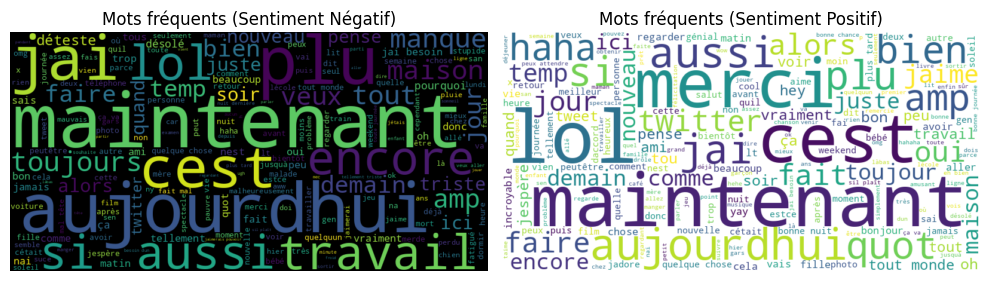

In [29]:
# Afficher les WordClouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Mots fréquents (Sentiment Négatif)")
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mots fréquents (Sentiment Positif)")
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
# Transformer les tweets en vecteurs avec TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)  # Limiter à 10000 mots les plus fréquents
X = vectorizer.fit_transform(data['cleaned_text']).toarray()
y = data['label']

In [31]:
# Diviser les données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Forme des données d'entraînement:", X_train.shape)
print("Forme des données de test:", X_test.shape)

Forme des données d'entraînement: (80000, 10000)
Forme des données de test: (20000, 10000)


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Construire un pipeline : StandardScaler + Logistic Regression
model = make_pipeline(
      StandardScaler(with_mean = False),
      LogisticRegression(random_state=42, max_iter=1000)  # max_iter augmenté pour convergence
  )

In [33]:
# Entraîner le modèle
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [34]:
# Prédictions sur les données de test
y_pred = model.predict(X_test)

Rapport de classification:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73     10035
           1       0.73      0.75      0.74      9965

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000



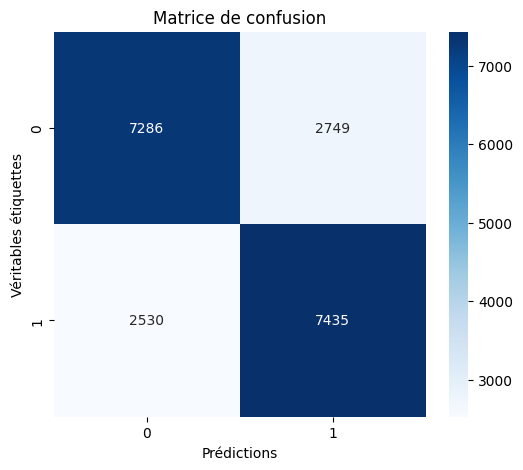

Exactitude: 0.73605


In [35]:
  # Rapport de classification
print("Rapport de classification:")
print(classification_report(y_test, y_pred))

  # Matrice de confusion (heatmap)
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Véritables étiquettes")
plt.show()

  # Exactitude
print("Exactitude:", accuracy_score(y_test, y_pred))

In [36]:
# Installe les dépendances manquantes (notebook / Kaggle / Colab)
!pip install --upgrade gradio gradio-client websockets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 26.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 56.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 21.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.


In [37]:
import gradio as gr

# Définir une fonction pour prédire le sentiment d'un texte
def predict_sentiment(text):
    cleaned_text = clean_text(text)
    vectorized_text = vectorizer.transform([cleaned_text])
    prediction = model.predict(vectorized_text)
    return "Positif" if prediction[0] == 1 else "Négatif"

# Nouvelle API Gradio
with gr.Blocks() as demo:
    gr.Markdown("# Analyse de Sentiment des Tweets en Français")
    gr.Markdown("Ce modèle prédit si un tweet a un sentiment positif ou négatif.")

    with gr.Row():
        text_input = gr.Textbox(label="Entrez un tweet en français")
        output_label = gr.Label(label="Sentiment")

    btn = gr.Button("Prédire")
    btn.click(fn=predict_sentiment, inputs=text_input, outputs=output_label)

# Lancer l'interface
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://a61a65f6648d2a1f23.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
